# Prove that BM is the only metric that can determine how similar a classifier is to random prediction

Matthews correlation coefficient (MCC) and Markedness (MK) are affected by prevalence. Bookmaker informedness (BM) is not.
In this notebook we simulate classifier results with known randomness to prove that BM is the only metric that truthfully measures how similar a classifier is to random guessing because it is independent of prevalence.

# Packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score
import tqdm

# Settings

Define how many samples are predicted. 
More samples mean that metrics (MCC, BM and MK) will be reproduced more closely.

In [2]:
N = int(2e5)

# Define Bookmaker informedness and markedness

In [3]:
def bm(gt, prediction):
    ba = balanced_accuracy_score(gt, prediction)
    return ba*2 - 1

In [4]:
def mk(gt, prediction):
    # see manuscript for deviation
    curr_bm = bm(gt, prediction)
    curr_mcc = matthews_corrcoef(gt, prediction)
    
    factor = curr_mcc / curr_bm
    
    mk = curr_bm * factor**2
    return mk

# Scan different values for prevalence, bias and lookup fraction

define step size for prevalence and bias scan

In [5]:
step = 0.05
prevs = np.arange(step, 1, step)
biases = np.arange(step, 1, step)

In [6]:
# how many different levels of prevalence and bias are there?
no_entries = len(prevs)

Define a function that generates the ground truth reference classes as well as the predictions (with the right lookup_fraction and bias).

In [7]:
def generate_classes_and_labels(lookup_fraction, prevalence, desired_bias):
    # in order to reach the desired_bias, 
    # one needs adjust the bias in the random predictions to the prevalence in the copied entries
    bias_for_remainder = (desired_bias - lookup_fraction * prevalence) / (1 - lookup_fraction)
    
    # some combinations of lookup_fraction and desired_bias are impossible to realize
    # don't calculate anything if bias for remaineder would need to be above one or below zero
    if bias_for_remainder > 1 or bias_for_remainder < 0:
        return None, None
    else:
        # generate reference classes randomly
        gt = np.random.binomial(1, prevalence, size=N)
        
        # lookup parts of the classes...
        copied_entries = int(lookup_fraction * N)
        lookedup = gt[:copied_entries]
        
        # ...and predict the remaining part (1-lookup_fraction) randomly...
        random_prediction = np.random.binomial(1, bias_for_remainder, size=N - copied_entries)
        # ...before merging the lookup part and the random predictions
        improved_prediction = np.concatenate([lookedup, random_prediction])
        return gt, improved_prediction

In [8]:
array_store = {}

# iterate over three values for lookup_fractions
for lookup_fraction in tqdm.tqdm_notebook([0.25, 0.5, 0.75]):

    # prepare arrays to store metrics in for all combinations of prevalence and bias
    bm_array = np.zeros((no_entries, no_entries))
    mcc_array = np.zeros((no_entries, no_entries))
    mk_array = np.zeros((no_entries, no_entries))

    # iterate over levels of prevalence...
    for a_idx, a in tqdm.tqdm_notebook(enumerate(prevs), total=no_entries):
        # ... and bias
        for b_idx, b in enumerate(biases):
            # get ground truth references and predicted labels
            ground_truth, improved_prediction = generate_classes_and_labels(lookup_fraction, a, b)

            # calculate BM, MCC and MK and store them in the corresponding arrays
            if improved_prediction is not None:
                bm_array[a_idx, b_idx] = bm(ground_truth, improved_prediction)
                mcc_array[a_idx, b_idx] = matthews_corrcoef(ground_truth, improved_prediction)
                mk_array[a_idx, b_idx] = mk(ground_truth, improved_prediction)
            else:
                bm_array[a_idx, b_idx] = np.nan
                mcc_array[a_idx, b_idx] = np.nan
                mk_array[a_idx, b_idx] = np.nan               
            
    array_store[lookup_fraction] = {'BM': bm_array, 'MCC': mcc_array, 'MK': mk_array}

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Plot the results

Define full names for prettier plotting

In [9]:
full_names = {'BM': "bookmaker informedness \n (BM)",
              'MCC': "Matthews correlation coefficient \n (MCC)",
              'MK': "markedness \n (MK)"}

/home/niklas/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


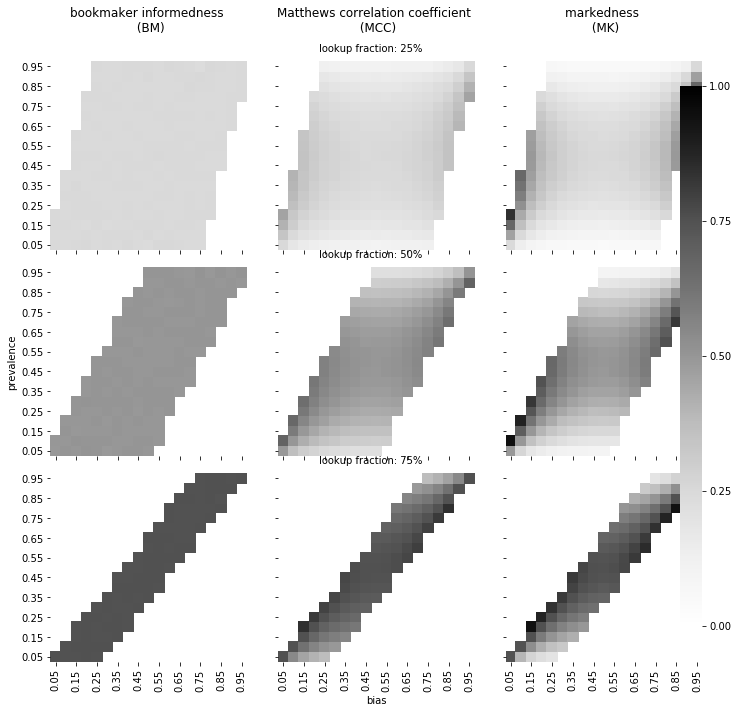

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.95, .125, .03, .75])

for col, i in enumerate([0.25, 0.5, 0.75]):
    for row, metric in enumerate(['BM', 'MCC', 'MK']):
        curr_df = pd.DataFrame(array_store[i][metric], 
                               index=['%3.2f' %x for x in prevs],
                               columns=['%3.2f' %x for x in biases])
        sns.heatmap(curr_df, vmin=0, vmax=1, ax=axes[col, row],                 
                    cbar_ax=cbar_ax,
                    cmap='Greys',
                    cbar_kws={"ticks":[0., 0.25, 0.5, 0.75, 1.]})
        axes[col, row].invert_yaxis()
    
        if col == 0:
            axes[0, row].set_title(full_names[metric], pad=30)           
    
        if row == 0:
            axes[row, col].set_ylabel('')
        
        if col == row:
            text = axes[col, 1].text(no_entries / 2, no_entries + 1, 'lookup fraction: %2.0f' % int(i *100) + '%',
                                    horizontalalignment='center')            

axes[1,0].set_ylabel('prevalence')
axes[2,1].set_xlabel('bias')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('randomness_measured_BM_MCC_MK.eps',bbox_inches='tight')
plt.tight_layout()